In [5]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

# Cargar Datos y Arreglo de fechas

In [6]:
df_pr = pd.read_csv('datos/precip_cr2met_day.csv')
df_qq = pd.read_csv('datos/q_mm_day.csv')

In [7]:
df_pr.head()

,date,year,month,day,9414001
0,1979-01-01,1979,1,1,0.0
1,1979-01-02,1979,1,2,0.0
2,1979-01-03,1979,1,3,0.0
3,1979-01-04,1979,1,4,0.0
4,1979-01-05,1979,1,5,0.0


In [8]:
df_qq.head()

,date,9414001
0,1900-01-01,NaN
1,1900-01-02,NaN
2,1900-01-03,NaN
3,1900-01-04,NaN
4,1900-01-05,NaN


## Definiendo limites

In [9]:
date_serie = pd.date_range(start='1/01/1979', end='31/12/2018', freq='D')

/Users/lequi/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3369: UserWarning: Parsing '31/12/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
date_serie

DatetimeIndex(['1979-01-01', '1979-01-02', '1979-01-03', '1979-01-04',
               '1979-01-05', '1979-01-06', '1979-01-07', '1979-01-08',
               '1979-01-09', '1979-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', length=14610, freq='D')

In [11]:
list(df_qq['date'])[0]

'1900-01-01'

In [12]:
str(date_serie[500])[:-9]

'1980-05-15'

In [13]:
start_date = '1979-01-01'
end_date = '2018-12-31'

In [14]:
list(df_qq['date']).index(start_date)

28854

In [15]:
list(df_qq['date']).index(end_date)

43463

In [16]:
date_qq = np.array(df_qq['date'][28854:43463+1])
qq = np.array(df_qq['9414001'][28854:43463+1])

In [17]:
list(df_pr['date']).index(end_date)

14609

In [18]:
date_pr = np.array(df_pr['date'][0:14609+1])
pr = np.array(df_pr['9414001'][0:14609+1])

In [19]:
print([len(pr), len(qq), len(date_serie)])

[14610, 14610, 14610]


No hay días faltantes

In [20]:
from tqdm import tqdm as tq

## Eliminacion de años bisiestos

In [21]:
date = []
qq_ = []
pr_ = []
for i in tq(range(0, len(date_serie))):
    if str(date_serie[i])[5:-9] != '02-29':
        qq_.append(qq[i])
        pr_.append(pr[i])
        date.append(date_serie[i])
    

100%|██████████████████████████████████| 14610/14610 [00:00<00:00, 83559.28it/s]


In [22]:
len(date)/365

40.0

In [23]:
df = pd.DataFrame({'date':date,
                  'pr': pr_,
                  'qq': qq_ })

len(df)

14600

# 1. Analisis armónico

In [24]:
qq_cicle = np.split(np.array(df['qq']), 40)
qq_cicle = np.array(qq_cicle).T

qq_cicle_mean = np.nanmean(qq_cicle, axis=1)


pr_cicle = np.split(np.array(df['pr']), 40)
pr_cicle = np.array(pr_cicle).T

pr_cicle_mean = np.nanmean(pr_cicle, axis=1)

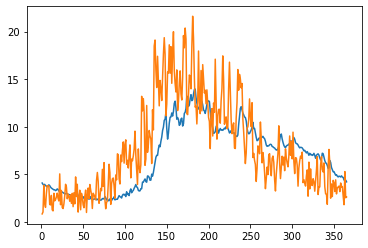

In [25]:
plt.plot(list(range(1, 366)), qq_cicle_mean)
plt.plot(list(range(1, 366)), pr_cicle_mean)

In [26]:
def armonico(x, T):
    return [np.cos((2.0*np.pi*x)/T), np.sin((2.0*np.pi*x)/T), 
            np.cos((2.0*np.pi*x)/(T/2)), np.sin((2.0*np.pi*x)/(T/2)),
            np.cos((2.0*np.pi*x)/(T/3)), np.sin((2.0*np.pi*x)/(T/3))]

In [27]:
from sklearn import linear_model

df.fillna(df.mean(), inplace=True)

y = df['qq']

t = np.array(list(range(0, len(y))))
X = np.array(armonico(t, 365)).T

regr_qq = linear_model.LinearRegression()
regr_qq.fit(X, y)

/var/folders/vm/k8dh5m_x4d15bk5cwzk1zk1r0000gn/T/ipykernel_49800/37970206.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.fillna(df.mean(), inplace=True)


LinearRegression()

In [28]:
qq_ = regr_qq.predict([armonico(x,365) for x in range(1,14601)])

In [29]:
y = df['pr']

t = np.array(list(range(0, len(y))))
X = np.array(armonico(t, 365)).T

regr_pr = linear_model.LinearRegression()
regr_pr.fit(X, y)

LinearRegression()

In [30]:
pr_ = regr_pr.predict([armonico(x,365) for x in range(1,14601)])

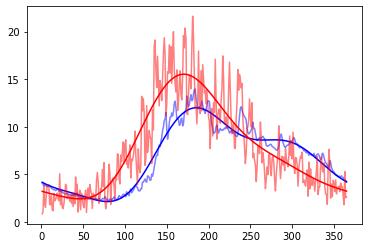

In [31]:
plt.plot(list(range(1, 366)), qq_cicle_mean, color = 'b', alpha=.5)
plt.plot(list(range(1, 366)), qq_[0:365], color = 'b')
plt.plot(list(range(1, 366)), pr_cicle_mean, color = 'r', alpha=.5)
plt.plot(list(range(1, 366)), pr_[0:365], color = 'r')

# 2. Analisis espectral

## Anomalias diarias

In [32]:
aqq = df['qq'].values - qq_
apr = df['pr'].values - pr_

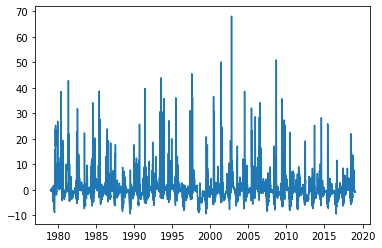

In [33]:
plt.plot(df['date'],aqq)

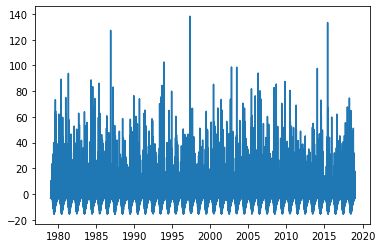

In [34]:
plt.plot(df['date'],apr)

## Espectro de anomalias

In [35]:
def espectro(x, T):
    AB=[]
    for k in range(1, 7301):
        AB.append(np.cos((2.0*k*np.pi*x)/T))
        AB.append(np.sin((2.0*k*np.pi*x)/T))
        
    return np.array(AB).T

In [36]:
t = np.array(list(range(1,14601)))

In [37]:
AB= espectro(t, 14600)
print(AB[0])

[ 9.99999907e-01  4.30355145e-04  9.99999630e-01 ...  4.30355145e-04
 -1.00000000e+00  1.22464680e-16]


In [38]:
np.shape(aqq)

(14600,)

In [ ]:
regr_qq = linear_model.LinearRegression()
tq(regr_qq.fit(AB, aqq))

regr_pr = linear_model.LinearRegression()
regr_pr.fit(AB, apr)

In [104]:
A_qq = [regr_qq.coef_[i] for i in range(0, len(regr_qq.coef_), 2)]
A_pr = [regr_pr.coef_[i] for i in range(0, len(regr_pr.coef_), 2)]

B_qq = [regr_qq.coef_[i+1] for i in range(0, len(regr_qq.coef_), 2)]
B_pr = [regr_pr.coef_[i+1] for i in range(0, len(regr_pr.coef_), 2)]

In [105]:
C_pr = [(A_pr[i]**2 + B_pr[i]**2)**(1/2) for i in range(0, len(A_pr))]
C_qq = [(A_qq[i]**2 + B_qq[i]**2)**(1/2) for i in range(0, len(A_qq))]

len(C_qq)

182

In [106]:
apr_ = regr_pr.predict([espectro(x,365).T for x in range(1,366)])
aqq_ = regr_qq.predict([espectro(x,365).T for x in range(1,366)])

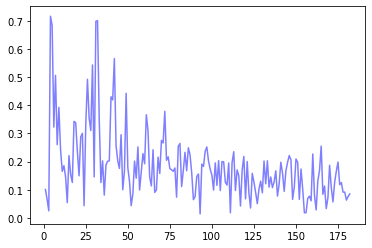

In [108]:
plt.plot(list(range(1, 183)), C_pr, color = 'b', alpha=.5)
#plt.plot(list(range(1, 366)), aqq_, color = 'b')
#plt.plot(list(range(1, 366)), apr, color = 'r', alpha=.5)
#plt.plot(list(range(1, 366)), apr_, color = 'r')

In [49]:
def fase_phi(A,B):
    phi = []
    for k in range(0,len(A)):
        if A[k]>0:
            phi.append(np.arctan(B[k]/A[k]))
        elif A[k]<0:
            phi.append(np.arctan(B[k]/A[k])+np.pi)
        elif A[K]==0:
            phi.append(np.pi/2)
    return np.array(phi)

In [52]:
phi_pr = fase_phi(A_pr, B_pr)
phi_qq = fase_phi(A_qq, B_qq)

In [171]:
plt.plot(list(range(1, 366)), aqq, color = 'b', alpha=.5)
plt.plot(list(range(1, 366)), , color = 'b')
plt.plot(list(range(1, 366)), pr_cicle_mean, color = 'r', alpha=.5)
plt.plot(list(range(1, 366)), pr_, color = 'r')

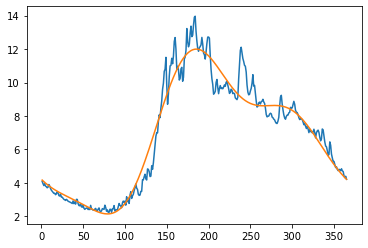